# Energy Preserving Operator Inference Optimization Example using Periodic BC Burger's Equation

In this notebook, we conduct the numerical experiment for the energy-preserving Operator Inference (ep-OpInf) for both the hard equality constraint and soft inequality constraint.

## Packages

In [1]:
using CSV
using DataFrames
using FileIO
using JLD2
using LaTeXStrings
using LinearAlgebra
using NaNStatistics
using Plots
using ProgressMeter
using Random
using SparseArrays
using Statistics
using Tables
;

## Initial Setup

In [2]:
include("../src/model/Burgers.jl")
include("../src/LiftAndLearn.jl")
LnL = LiftAndLearn
;

┌ Warning: Replacing docs for `Main.LiftAndLearn.F2Hs :: Tuple{Any}` in module `Main.LiftAndLearn`
└ @ Base.Docs docs\Docs.jl:240


In [3]:
# First order Burger's equation setup
burger = Burgers(
    [0.0, 1.0], [0.0, 1.0], [0.05, 0.15],
    2^(-7), 1e-4, 10, "periodic"
)
;

#### Run below to change to periodic boundary condition
- Initial condition to: sinusoidal wave
- Zero boundary condition

In [4]:
burger.IC = sin.(2 * pi * burger.x)  
# ic_a = range(0.95, 1.05, 3) # coefficient that changes the initial condition for training data
ic_a = 1.0
;  

## Energy Preserving Constraint Optimization

Which test:
- test1: using intrusive operators as initial guess
- test2: using identity initial guess
- test3: using operators computed as a convex combination of the least-square solution and intrusive operator as initial guess

In [5]:
test = 2
if test == 1
    filename = "data/epOpInf_periodic_data_01.jld2"
elseif test == 2
    filename = "data/epOpInf_periodic_data_02.jld2"
elseif test == 3
    filename = "data/epOpInf_periodic_data_03.jld2"
end
;

### Important Parameters

In [7]:
num_ICs = length(ic_a)

# Minimum and maximum dimensions
rmin = 1
rmax = 15

burger_system = LnL.sys_struct(
    is_lin=true,
    is_quad=true,
)
burger_vars = LnL.vars(
    N=1,
)
burger_data = LnL.data(
    Δt=1e-4,
    DS=5,
)
burger_optim = LnL.opt_settings(
    verbose=true,
    initial_guess=true,
)

options = LnL.EPUC_options(
    system=burger_system,
    vars=burger_vars,
    data=burger_data,
    optim=burger_optim,
    λ_quad=0.0001,
    α=1e5,
)

# Downsampling rate
DS = options.data.DS
;

### Generate Training Data

In [9]:
# Store values
Xtr = Vector{Matrix{Float64}}(undef, burger.Pdim)
Rtr = Vector{Matrix{Float64}}(undef, burger.Pdim)
Xtr_all = Vector{Matrix{Float64}}(undef, burger.Pdim)
Vrmax = Vector{Matrix{Float64}}(undef, burger.Pdim)
op_fom_tr = Vector{LnL.operators}(undef, burger.Pdim)

@info "Generate the FOM system matrices and training data."
@showprogress for i in 1:length(burger.μs)
    μ = burger.μs[i]
    
    # Generate the FOM system matrices 
    A, F = burger.generateEPmatrix(burger, μ)
    op_fom_tr[i] = LnL.operators(A=A, F=F)
    Xtr_all[i] = burger.semiImplicitEuler(A, F, burger.t, burger.IC)
    
    ## training data for OpInf
    Xall = Vector{Matrix{Float64}}(undef, num_ICs)
    Xdotall = Vector{Matrix{Float64}}(undef, num_ICs)
    for j in 1:num_ICs
        states = burger.semiImplicitEuler(A, F, burger.t, ic_a[j] * burger.IC)
            
        tmp = states[:, 2:end]
        Xall[j] = tmp[:, 1:DS:end]  # downsample data
        tmp = (states[:, 2:end] - states[:, 1:end-1]) / burger.Δt
        Xdotall[j] = tmp[:, 1:DS:end]  # downsample data
    end
    Xtr[i] = reduce(hcat, Xall)
    Rtr[i] = reduce(hcat, Xdotall)
    
    # Compute the POD basis from the training data
    tmp = svd(Xtr[i])
    Vrmax[i] = tmp.U[:, 1:rmax]
end

Data = Dict("Xtr" => Xtr, "Rtr" => Rtr, "Vrmax" => Vrmax, 
        "op_fom_tr" => op_fom_tr, "Xtr_all" => Xtr_all)
@save filename Data

┌ Info: Generate the FOM system matrices and training data.
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\08_ep-burgers_ep-OpInf.ipynb:8


Progress:  20%|█████████                                |  ETA: 0:08:40

Progress:  30%|█████████████                            |  ETA: 0:07:27

Progress:  40%|█████████████████                        |  ETA: 0:06:19

Progress:  50%|█████████████████████                    |  ETA: 0:05:15

Progress:  60%|█████████████████████████                |  ETA: 0:04:12

Progress:  70%|█████████████████████████████            |  ETA: 0:03:09

Progress:  80%|█████████████████████████████████        |  ETA: 0:02:06

Progress:  90%|█████████████████████████████████████    |  ETA: 0:01:02

Progress: 100%|█████████████████████████████████████████| Time: 0:10:23


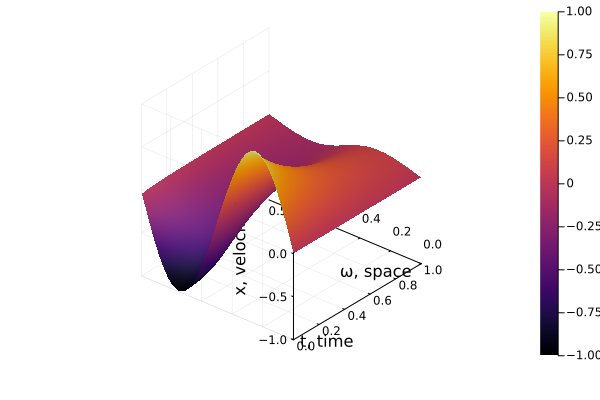

In [10]:
# Verify the training data
surface(burger.t, burger.x, Xtr_all[1], camera=(-50,30), xlabel="t, time", ylabel="ω, space", zlabel="u(x,t)")

In [ ]:

plot(contour(burger.t, burger.x, Xtr_all[1], fill=true))

### Obtain Least Square Solution

In [11]:
@info "Compute the Least Squares solution."

# Store values
op_LS = Array{LnL.operators}(undef, burger.Pdim)
options.λ_LS = 0.0                  # Tikhonov regularization parameter
options.LS_pinv_tol = 1e-7          # tolerance for pseudo-inverse

# Load the data dictionary
if !(@isdefined Data)
    @info "Loading data from epOpInf_periodic_data.jld2"
    if !isfile(filename)
        error("Run the cell above to generate the data first!")
    end
    Data = load(filename)
    Xtr = Data["Xtr"]
    Rtr = Data["Rtr"]
    Vrmax = Data["Vrmax"]
    @info "Data loaded."
end

@showprogress for i in 1:length(burger.μs)
    op_LS[i] = LnL.inferOp(Xtr[i], zeros(1,1), zeros(1,1), Vrmax[i], Vrmax[i]' * Rtr[i], options)
end

# Save to data
Data["op_LS"] = op_LS
save(filename, Data)

┌ Info: Compute the Least Squares solution.
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\08_ep-burgers_ep-OpInf.ipynb:1


┌ Warning: Rank difficient, rank = 22, tol = 9.658485018759531e-8.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\learn.jl:87


┌ Warning: Rank difficient, rank = 22, tol = 3.773812498895853e-8.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\learn.jl:87
Progress:  20%|█████████                                |  ETA: 0:00:38

┌ Warning: Rank difficient, rank = 22, tol = 6.10624223067826e-8.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\learn.jl:87


┌ Warning: Rank difficient, rank = 21, tol = 9.384620752907473e-8.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\learn.jl:87
Progress:  40%|█████████████████                        |  ETA: 0:00:14

┌ Warning: Rank difficient, rank = 21, tol = 4.294474736573526e-8.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\learn.jl:87


┌ Warning: Rank difficient, rank = 21, tol = 5.849960817072792e-8.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\learn.jl:87
Progress:  60%|█████████████████████████                |  ETA: 0:00:06

┌ Warning: Rank difficient, rank = 21, tol = 7.147221065217998e-8.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\learn.jl:87


┌ Warning: Rank difficient, rank = 21, tol = 7.040005061147994e-8.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\learn.jl:87
Progress:  80%|█████████████████████████████████        |  ETA: 0:00:02

┌ Warning: Rank difficient, rank = 21, tol = 5.67807871120425e-8.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\learn.jl:87


┌ Warning: Rank difficient, rank = 21, tol = 4.214032530704301e-8.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\learn.jl:87
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


### Obtain intrusive operators 

In [12]:
@info "Compute the intrusive model"

# Store values
op_int = Array{LnL.operators}(undef, burger.Pdim)

# Load the data dictionary
if !(@isdefined Data)
    @info "Loading data from epOpInf_periodic_data.jld2"
    if !isfile(filename)
        error("Run the cell above to generate the data first!")
    end
    Data = load(filename)
    Vrmax = Data["Vrmax"]
    op_fom_tr = Data["op_fom_tr"]
    @info "Data loaded."
end

for i in 1:length(burger.μs)
    # Compute the values for the intrusive model from the basis of the training data
    op_int[i] = LnL.intrusiveMR(op_fom_tr[i], Vrmax[i], options)
    @info "Loop $(i) out of 10 completed..."
end

# Save to data
Data["op_int"] = op_int
save(filename, Data)

┌ Info: Compute the intrusive model
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\08_ep-burgers_ep-OpInf.ipynb:1


┌ Info: Loop 1 out of 10 completed...
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\08_ep-burgers_ep-OpInf.ipynb:21
┌ Info: Loop 2 out of 10 completed...
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\08_ep-burgers_ep-OpInf.ipynb:21
┌ Info: Loop 3 out of 10 completed...
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\08_ep-burgers_ep-OpInf.ipynb:21
┌ Info: Loop 4 out of 10 completed...
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\08_ep-burgers_ep-OpInf.ipynb:21
┌ Info: Loop 5 out of 10 completed...
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\08_ep-burgers_ep-OpInf.ipynb:21
┌ Info: Loop 6 out of 10 completed...
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\08_ep-burgers_ep-OpInf.ipynb:21
┌ Info: Loop 7 out of 10 completed...
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\08_ep-burgers_ep-OpInf.ipynb:21
┌ Info: Loop 8 out of 10 completed...
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\08_ep-burgers_ep-OpInf.i

### Generate Random Initial Guess for Optimization

In [13]:
if test == 2
    # Load the data dictionary
    foo = rmax
    baz = 1.0I(foo)
    pux = zeros(foo, foo, foo)
    for i in 1:foo
        pux[:,:,i] .= 1.0I(foo)
    end
    op_guess = LnL.operators(A=Matrix(baz), F=Matrix(LnL.H2F(LnL.Q2H(pux))))
elseif test == 3
    # Load the data dictionary
    if !(@isdefined Data)
        @info "Loading data from epOpInf_periodic_data.jld2"
        if !isfile(filename)
            error("Run the cell above to generate the data first!")
        end
        Data = load(filename)
        op_LS = Data["op_LS"]
        op_int = Data["op_int"]
        @info "Data loaded."
    end

    op_guess = Array{LnL.operators}(undef, burger.Pdim)
    β = rand(1)[1]
    for i in 1:length(burger.μs)
        Arand = β * op_LS[i].A .+ (1 - β) * op_int[i].A + randn(size(op_LS[i].A))
        Frand = β * op_LS[i].F .+ (1 - β) * op_int[i].F + randn(size(op_LS[i].F))
        op_guess[i] = LnL.operators(A=Arand, F=Frand)
    end

    Data["op_guess"] = op_guess
    save(filename, Data)
end
;

### Obtain the Non-Constrained OpInf Operators

In [13]:
@info "Compute the nc-OpInf model"

options.optimization = "NCT"

# Store values
op_nc_opinf = Array{LnL.operators}(undef, burger.Pdim)

# Load the data dictionary
if !(@isdefined Data)
    @info "Loading data from epOpInf_periodic_data.jld2"
    if !isfile(filename)
        error("Run the cell above to generate the data first!")
    end
    Data = load(filename)
    op_LS = Data["op_LS"]
    op_int = Data["op_int"]
    # op_guess = test == 3 ? Data["op_guess"] : nothing
    Xtr = Data["Xtr"]
    Rtr = Data["Rtr"]
    Vrmax = Data["Vrmax"]
    @info "Data loaded."
end

for i in 1:length(burger.μs)
    # Compute non-constrained OpInf
    if test == 1
        op_nc_opinf[i] = LnL.inferOp(Xtr[i], zeros(1,1), zeros(1,1), Vrmax[i], Vrmax[i]' * Rtr[i], options, op_int[i])
    elseif test == 2
        options.initial_guess_for_opt = false
        op_nc_opinf[i] = LnL.inferOp(Xtr[i], zeros(1,1), zeros(1,1), Vrmax[i], Vrmax[i]' * Rtr[i], options)
    elseif test == 3
        op_nc_opinf[i] = LnL.inferOp(Xtr[i], zeros(1,1), zeros(1,1), Vrmax[i], Vrmax[i]' * Rtr[i], options, op_guess[i])
    end
    @info "Loop $(i) out of 10 completed..."
end

# Save to data
Data["op_nc_opinf"] = op_nc_opinf
save(filename, Data)

┌ Info: Compute the nc-OpInf model
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\08_ep-burgers_ep-OpInf.ipynb:1


┌ Info: Initialize optimization model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NCT_Optimize.jl:24


┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NCT_Optimize.jl:60



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.10, running with linear solver MUMPS 5.5.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   137700

Total number of variables............................:     2025
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality c

┌ Info: Optimize model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NCT_Optimize.jl:62
┌ Info: 
│ 
│ Constraint           = Non-Constrained 
│ Tikhonov             = 0.02
│ Warm Start           = false
│ order                = 15
│ solve time           = 0.1639997959136963
│ termination_status   = LOCALLY_SOLVED
│ primal_status        = FEASIBLE_POINT
│ dual_state           = FEASIBLE_POINT
│ dual objective value = 294049.7347709876
│ objective_value      = 1866.4240945021986
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NCT_Optimize.jl:64
┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NCT_Optimize.jl:88
┌ Info: Loop 1 out of 10 completed...
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\08_ep-burgers_ep-OpInf.ipynb:34


This is Ipopt version 3.14.10, running with linear solver MUMPS 5.5.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   137700

Total number of variables............................:     2025
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.3325878e+05 0.00e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

┌ Info: Initialize optimization model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NCT_Optimize.jl:24
┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NCT_Optimize.jl:60
┌ Info: Optimize model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NCT_Optimize.jl:62
┌ Info: 
│ 
│ Constraint           = Non-Constrained 
│ Tikhonov             = 0.02
│ Warm Start           = false
│ order                = 15
│ solve time           = 0.042999982833862305
│ termination_status   = LOCALLY_SOLVED
│ primal_status        = FEASIBLE_POINT
│ dual_state           = FEASIBLE_POINT
│ dual objective value = 533258.7845115949
│ objective_value      = 4382.592249503862
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NCT_Optimize.jl:64
┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NCT_Optimize.jl:88
┌ Info: Loop 2 out of 10 completed...
└ @ Main c:

This is Ipopt version 3.14.10, running with linear solver MUMPS 5.5.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   137700

Total number of variables............................:     2025
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.8523410e+05 0.00e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NCT_Optimize.jl:60
┌ Info: Optimize model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NCT_Optimize.jl:62
┌ Info: 
│ 
│ Constraint           = Non-Constrained 
│ Tikhonov             = 0.02
│ Warm Start           = false
│ order                = 15
│ solve time           = 0.03299999237060547
│ termination_status   = LOCALLY_SOLVED
│ primal_status        = FEASIBLE_POINT
│ dual_state           = FEASIBLE_POINT
│ dual objective value = 785234.1038459265
│ objective_value      = 6477.336512580605
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NCT_Optimize.jl:64
┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\NCT_Optimize.jl:88
┌ Info: Loop 3 out of 10 completed...
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\08_ep-burgers_ep-OpInf.ipynb:34


### Obtain operators for EPHEC-OpInf

In [ ]:
@info "Compute the EPHEC OpInf."

# Switch optimization scheme
options.optimization = "EPHEC"
options.max_iter = 5000

# Store values
op_ephec_opinf = Array{LnL.operators}(undef, burger.Pdim)

# Load the data dictionary
if !(@isdefined Data)
    @info "Loading data from epOpInf_periodic_data.jld2"
    if !isfile(filename)
        error("Run the cell above to generate the data first!")
    end
    Data = load(filename)
    # op_guess = test==3 ? Data["op_rand"] : nothing
    Xtr = Data["Xtr"]
    Rtr = Data["Rtr"]
    Vrmax = Data["Vrmax"]
    op_int = Data["op_int"]
    @info "Data loaded."
end

@info "Compute the ephec-OpInf operators"
for i in 1:length(burger.μs)
    # Compute non-constrained OpInf (the initial guess is the non-constrained operator inference operators)
    if test == 1
        op_ephec_opinf[i] = LnL.inferOp(Xtr[i], zeros(1,1), zeros(1,1), Vrmax[i], Vrmax[i]' * Rtr[i], options, op_int[i])
    elseif test == 2
        options.initial_guess_for_opt = false
        op_ephec_opinf[i] = LnL.inferOp(Xtr[i], zeros(1,1), zeros(1,1), Vrmax[i], Vrmax[i]' * Rtr[i], options)
    elseif test == 3
        op_ephec_opinf[i] = LnL.inferOp(Xtr[i], zeros(1,1), zeros(1,1), Vrmax[i], Vrmax[i]' * Rtr[i], options, op_guess[i])
    end
    @info "Loop $(i) out of 10 completed..."
end

# Save to data
Data["op_ephec_opinf"] = op_ephec_opinf
save(filename, Data)

### Obtain operators for EPSIC-OpInf

In [ ]:
@info "Compute the EPSIC OpInf."

# Switch optimization scheme
options.optimization = "EPSIC"
options.ϵ_ep = 1e-10

# Store values
op_epsic_opinf = Array{LnL.operators}(undef, burger.Pdim)

# Load the data dictionary
if !(@isdefined Data)
    @info "Loading data from epOpInf_periodic_data.jld2"
    if !isfile(filename)
        error("Run the cell above to generate the data first!")
    end
    Data = load(filename)
    Xtr = Data["Xtr"]
    Rtr = Data["Rtr"]
    Vrmax = Data["Vrmax"]
    op_int = Data["op_int"]
    op_rand = test==3 ? Data["op_rand"] : nothing
    @info "Data loaded."
end

@info "Compute the epsic-OpInf operators"
for i in 1:length(burger.μs)
    # Compute non-constrained OpInf (the initial guess is the non-constrained operator inference operators)
    if test == 1
        op_epsic_opinf[i] = LnL.inferOp(Xtr[i], zeros(1,1), zeros(1,1), Vrmax[i], Vrmax[i]' * Rtr[i], options, op_int[i])
    elseif test == 2
        options.initial_guess_for_opt = false
        op_epsic_opinf[i] = LnL.inferOp(Xtr[i], zeros(1,1), zeros(1,1), Vrmax[i], Vrmax[i]' * Rtr[i], options)
    elseif test == 3
        op_epsic_opinf[i] = LnL.inferOp(Xtr[i], zeros(1,1), zeros(1,1), Vrmax[i], Vrmax[i]' * Rtr[i], options, op_guess[i])
    end
    @info "Loop $(i) out of 10 completed..."
end

# Save to data
Data["op_epsic_opinf"] = op_epsic_opinf
save(filename, Data)

### Obtain operators for EPUC-OpInf

In [14]:
@info "Compute the EPUC OpInf."

# Switch optimization scheme
options.optimization = "EPUC"
options.max_iter = 5000

# Store values
op_epuc_opinf = Array{LnL.operators}(undef, burger.Pdim)

# Load the data dictionary
if !(@isdefined Data)
    @info "Loading data from epOpInf_periodic_data.jld2"
    if !isfile(filename)
        error("Run the cell above to generate the data first!")
    end
    Data = load(filename)
    # op_guess = test==3 ? Data["op_rand"] : nothing
    Xtr = Data["Xtr"]
    Rtr = Data["Rtr"]
    Vrmax = Data["Vrmax"]
    op_int = Data["op_int"]
    @info "Data loaded."
end

@info "Compute the EPUC-OpInf operators"
for i in 1:length(burger.μs)
    # Compute non-constrained OpInf (the initial guess is the non-constrained operator inference operators)
    if test == 1
        op_epuc_opinf[i] = LnL.inferOp(Xtr[i], zeros(1,1), zeros(1,1), Vrmax[i], Vrmax[i]' * Rtr[i], options, op_int[i])
    elseif test == 2
        options.initial_guess_for_opt = false
        op_epuc_opinf[i] = LnL.inferOp(Xtr[i], zeros(1,1), zeros(1,1), Vrmax[i], Vrmax[i]' * Rtr[i], options)
    elseif test == 3
        op_epuc_opinf[i] = LnL.inferOp(Xtr[i], zeros(1,1), zeros(1,1), Vrmax[i], Vrmax[i]' * Rtr[i], options, op_guess[i])
    end
    @info "Loop $(i) out of 10 completed..."
end

# Save to data
Data["op_epuc_opinf"] = op_epuc_opinf
save(filename, Data)

┌ Info: Compute the EPUC OpInf.
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\08_ep-burgers_ep-OpInf.ipynb:1
┌ Info: Compute the EPUC-OpInf operators
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\08_ep-burgers_ep-OpInf.ipynb:25


┌ Info: Initialize optimization model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:518


┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:584



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.10, running with linear solver MUMPS 5.5.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   139275

Total number of variables............................:     2025
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality c

┌ Info: Optimize model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:586
┌ Info: [EP-OpInf Results]
│ Constraint           = Energy-Preserving Unconstrained
│ Linear Regulation    = 0
│ Quadratic Regulation = 0.01
│ Warm Start           = false
│ order                = 15
│ solve time           = 0.13199996948242188
│ termination_status   = LOCALLY_SOLVED
│ primal_status        = FEASIBLE_POINT
│ dual_state           = FEASIBLE_POINT
│ dual objective value = 200777.51195839443
│ objective_value      = 0.0013991654215841673
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:588
┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:608
┌ Info: Loop 1 out of 10 completed...
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\08_ep-burgers_ep-OpInf.ipynb:36


This is Ipopt version 3.14.10, running with linear solver MUMPS 5.5.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   139275

Total number of variables............................:     2025
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.1682315e+05 0.00e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

┌ Info: Initialize optimization model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:518
┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:584
┌ Info: Optimize model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:586
┌ Info: [EP-OpInf Results]
│ Constraint           = Energy-Preserving Unconstrained
│ Linear Regulation    = 0
│ Quadratic Regulation = 0.01
│ Warm Start           = false
│ order                = 15
│ solve time           = 0.0820000171661377
│ termination_status   = LOCALLY_SOLVED
│ primal_status        = FEASIBLE_POINT
│ dual_state           = FEASIBLE_POINT
│ dual objective value = 216823.14782089158
│ objective_value      = 0.0025363808654503975
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:588
┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optim

┌ Info: Loop 2 out of 10 completed...
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\08_ep-burgers_ep-OpInf.ipynb:36
┌ Info: Initialize optimization model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:518


This is Ipopt version 3.14.10, running with linear solver MUMPS 5.5.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   139275

Total number of variables............................:     2025
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.3620421e+05 0.00e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:584
┌ Info: Optimize model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:586
┌ Info: [EP-OpInf Results]
│ Constraint           = Energy-Preserving Unconstrained
│ Linear Regulation    = 0
│ Quadratic Regulation = 0.01
│ Warm Start           = false
│ order                = 15
│ solve time           = 0.06699991226196289
│ termination_status   = LOCALLY_SOLVED
│ primal_status        = FEASIBLE_POINT
│ dual_state           = FEASIBLE_POINT
│ dual objective value = 236204.2065112066
│ objective_value      = 0.0028629399873264585
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:588
┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:608
┌ Info: Loop 3 out of 10 completed...
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\08_ep-burgers_ep-OpInf.ipyn

┌ Info: Initialize optimization model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:518


This is Ipopt version 3.14.10, running with linear solver MUMPS 5.5.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   139275

Total number of variables............................:     2025
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.5769293e+05 0.00e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:584
┌ Info: Optimize model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:586
┌ Info: [EP-OpInf Results]
│ Constraint           = Energy-Preserving Unconstrained
│ Linear Regulation    = 0
│ Quadratic Regulation = 0.01
│ Warm Start           = false
│ order                = 15
│ solve time           = 0.05899977684020996
│ termination_status   = LOCALLY_SOLVED
│ primal_status        = FEASIBLE_POINT
│ dual_state           = FEASIBLE_POINT
│ dual objective value = 257692.92551420195
│ objective_value      = 0.002911696062609983
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:588


┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:608
┌ Info: Loop 4 out of 10 completed...
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\08_ep-burgers_ep-OpInf.ipynb:36


This is Ipopt version 3.14.10, running with linear solver MUMPS 5.5.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   139275

Total number of variables............................:     2025
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.8061352e+05 0.00e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

┌ Info: Initialize optimization model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:518
┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:584
┌ Info: Optimize model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:586
┌ Info: [EP-OpInf Results]
│ Constraint           = Energy-Preserving Unconstrained
│ Linear Regulation    = 0
│ Quadratic Regulation = 0.01
│ Warm Start           = false
│ order                = 15
│ solve time           = 0.07500004768371582
│ termination_status   = LOCALLY_SOLVED
│ primal_status        = FEASIBLE_POINT
│ dual_state           = FEASIBLE_POINT
│ dual objective value = 280613.521443101
│ objective_value      = 0.003008945330206244
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:588


┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:608
┌ Info: Loop 5 out of 10 completed...
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\08_ep-burgers_ep-OpInf.ipynb:36
┌ Info: Initialize optimization model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:518


┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:584
┌ Info: Optimize model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:586


This is Ipopt version 3.14.10, running with linear solver MUMPS 5.5.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   139275

Total number of variables............................:     2025
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.0455908e+05 0.00e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

┌ Info: [EP-OpInf Results]
│ Constraint           = Energy-Preserving Unconstrained
│ Linear Regulation    = 0
│ Quadratic Regulation = 0.01
│ Warm Start           = false
│ order                = 15
│ solve time           = 0.10699987411499023
│ termination_status   = LOCALLY_SOLVED
│ primal_status        = FEASIBLE_POINT
│ dual_state           = FEASIBLE_POINT
│ dual objective value = 304559.08256324567
│ objective_value      = 0.0030503226517802186
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:588
┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:608
┌ Info: Loop 6 out of 10 completed...
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\08_ep-burgers_ep-OpInf.ipynb:36
┌ Info: Initialize optimization model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:518


This is Ipopt version 3.14.10, running with linear solver MUMPS 5.5.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   139275

Total number of variables............................:     2025
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.2926565e+05 0.00e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:584
┌ Info: Optimize model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:586
┌ Info: [EP-OpInf Results]
│ Constraint           = Energy-Preserving Unconstrained
│ Linear Regulation    = 0
│ Quadratic Regulation = 0.01
│ Warm Start           = false
│ order                = 15
│ solve time           = 0.06299996376037598
│ termination_status   = LOCALLY_SOLVED
│ primal_status        = FEASIBLE_POINT
│ dual_state           = FEASIBLE_POINT
│ dual objective value = 329265.65222574596
│ objective_value      = 0.0030575863368923098
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:588
┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:608
┌ Info: Loop 7 out of 10 completed...
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\08_ep-burgers_ep-OpInf.ipy

┌ Info: Initialize optimization model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:518


This is Ipopt version 3.14.10, running with linear solver MUMPS 5.5.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   139275

Total number of variables............................:     2025
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.5455262e+05 0.00e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:584
┌ Info: Optimize model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:586
┌ Info: [EP-OpInf Results]
│ Constraint           = Energy-Preserving Unconstrained
│ Linear Regulation    = 0
│ Quadratic Regulation = 0.01
│ Warm Start           = false
│ order                = 15
│ solve time           = 0.051999807357788086
│ termination_status   = LOCALLY_SOLVED
│ primal_status        = FEASIBLE_POINT
│ dual_state           = FEASIBLE_POINT
│ dual objective value = 354552.62408182945
│ objective_value      = 0.003061967358596651
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:588
┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:608
┌ Info: Loop 8 out of 10 completed...
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\08_ep-burgers_ep-OpInf.ipy

This is Ipopt version 3.14.10, running with linear solver MUMPS 5.5.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   139275

Total number of variables............................:     2025
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.8029181e+05 0.00e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:584
┌ Info: Optimize model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:586
┌ Info: [EP-OpInf Results]
│ Constraint           = Energy-Preserving Unconstrained
│ Linear Regulation    = 0
│ Quadratic Regulation = 0.01
│ Warm Start           = false
│ order                = 15
│ solve time           = 0.06800007820129395
│ termination_status   = LOCALLY_SOLVED
│ primal_status        = FEASIBLE_POINT
│ dual_state           = FEASIBLE_POINT
│ dual objective value = 380291.8126808827
│ objective_value      = 0.0030644532707581502
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:588


┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:608
┌ Info: Loop 9 out of 10 completed...
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\08_ep-burgers_ep-OpInf.ipynb:36
┌ Info: Initialize optimization model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:518


This is Ipopt version 3.14.10, running with linear solver MUMPS 5.5.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   139275

Total number of variables............................:     2025
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.0638982e+05 0.00e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:584
┌ Info: Optimize model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:586
┌ Info: [EP-OpInf Results]
│ Constraint           = Energy-Preserving Unconstrained
│ Linear Regulation    = 0
│ Quadratic Regulation = 0.01
│ Warm Start           = false
│ order                = 15
│ solve time           = 0.06799983978271484
│ termination_status   = LOCALLY_SOLVED
│ primal_status        = FEASIBLE_POINT
│ dual_state           = FEASIBLE_POINT
│ dual objective value = 406389.8177387013
│ objective_value      = 0.0030657650215668475
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:588
┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:608


┌ Info: Loop 10 out of 10 completed...
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\08_ep-burgers_ep-OpInf.ipynb:36


### Test & Analyze (Training Data)

In [8]:
# Projection error
train_proj_err = zeros(rmax - (rmin-1), burger.Pdim) 
# Relative state error
train_state_err = Dict(
    :int => zeros(rmax-rmin+1, burger.Pdim),
    :LS => zeros(rmax-rmin+1, burger.Pdim),
    # :nc_OpInf => zeros(rmax-rmin+1, burger.Pdim),
    # :ephec_OpInf => zeros(rmax-rmin+1, burger.Pdim),
    # :epsic_OpInf => zeros(rmax-rmin+1, burger.Pdim)
    :epuc_OpInf => zeros(rmax-rmin+1, burger.Pdim),
)
# Energy 
train_En = Dict(
    :int => Array{VecOrMat{Float64}}(undef, rmax - (rmin - 1), burger.Pdim),
    :LS => Array{VecOrMat{Float64}}(undef, rmax - (rmin - 1), burger.Pdim),
    # :nc_OpInf => Array{VecOrMat{Float64}}(undef, rmax - (rmin - 1), burger.Pdim),
    # :ephec_OpInf => Array{VecOrMat{Float64}}(undef, rmax - (rmin - 1), burger.Pdim),
    # :epsic_OpInf => Array{VecOrMat{Float64}}(undef, rmax - (rmin - 1), burger.Pdim),
    :epuc_OpInf => Array{VecOrMat{Float64}}(undef, rmax - (rmin - 1), burger.Pdim),
    :fom => Array{VecOrMat{Float64}}(undef, burger.Pdim)
)
# Constraint Residual
train_CR = Dict(
    :int => Array{Float64}(undef, rmax - (rmin - 1), burger.Pdim),
    :LS => Array{Float64}(undef, rmax - (rmin - 1), burger.Pdim),
    # :nc_OpInf => Array{Float64}(undef, rmax - (rmin - 1), burger.Pdim),
    # :ephec_OpInf => Array{Float64}(undef, rmax - (rmin - 1), burger.Pdim),
    # :epsic_OpInf => Array{Float64}(undef, rmax - (rmin - 1), burger.Pdim),
    :epuc_OpInf => Array{Float64}(undef, rmax - (rmin - 1), burger.Pdim),
    :fom => Array{Float64}(undef, burger.Pdim)
)
# Momentum
train_mmt = Dict(
    :int => Array{Float64}(undef, rmax - (rmin - 1), burger.Pdim),
    :LS => Array{Float64}(undef, rmax - (rmin - 1), burger.Pdim),
    # :nc_OpInf => Array{Float64}(undef, rmax - (rmin - 1), burger.Pdim),
    # :ephec_OpInf => Array{Float64}(undef, rmax - (rmin - 1), burger.Pdim),
    # :epsic_OpInf => Array{Float64}(undef, rmax - (rmin - 1), burger.Pdim),
    :epuc_OpInf => Array{Float64}(undef, rmax - (rmin - 1), burger.Pdim),
    :fom => Array{Float64}(undef, burger.Pdim)
)
# Constraint Violation
train_CV = Dict(
    :int => Array{VecOrMat{Float64}}(undef, rmax - (rmin - 1), burger.Pdim),
    :LS => Array{VecOrMat{Float64}}(undef, rmax - (rmin - 1), burger.Pdim),
    # :nc_OpInf => Array{VecOrMat{Float64}}(undef, rmax - (rmin - 1), burger.Pdim),
    # :ephec_OpInf => Array{VecOrMat{Float64}}(undef, rmax - (rmin - 1), burger.Pdim),
    # :epsic_OpInf => Array{VecOrMat{Float64}}(undef, rmax - (rmin - 1), burger.Pdim),
    :epuc_OpInf => Array{VecOrMat{Float64}}(undef, rmax - (rmin - 1), burger.Pdim),
    :fom => Array{VecOrMat{Float64}}(undef, burger.Pdim)
)

# Load the data dictionary
if !(@isdefined Data)
    @info "Loading data from epOpInf_periodic_data.jld2"
    if !isfile(filename)
        error("Run the cell above to generate the data first!")
    end
    Data = load(filename)
    @info "Data loaded."
end

@info "Analyze the operators with training data..."
@showprogress for i in 1:length(burger.μs)
    op_LS = Data["op_LS"][i]
    op_int = Data["op_int"][i]
    # op_nc_opinf = Data["op_nc_opinf"][i]
    # op_ephec_opinf = Data["op_ephec_opinf"][i]
    # op_epsic_opinf = Data["op_epsic_opinf"][i]
    op_epuc_opinf = Data["op_epuc_opinf"][i]
    
    Xtrain = Data["Xtr_all"][i]
    Vrmax_ = Data["Vrmax"][i]
    
    # Energy of the FOM
    train_En[:fom][i] = norm.(eachcol(Xtrain), 2)
    F_full = Data["op_fom_tr"][i].F
    train_CR[:fom][i], train_mmt[:fom][i] = LnL.constraintResidual(F_full, size(F_full, 1), options.which_quad_term)
    train_CV[:fom][i] = LnL.constraintViolation(Xtrain, F_full, options.which_quad_term)
    
    for (j,r) in enumerate(rmin:rmax)
        Vr = Vrmax_[:, 1:r]

        # Integrate the LS operator inference model
        Finf_extract_LS = LnL.extractF(op_LS.F, r)
        Xinf_LS = burger.semiImplicitEuler(op_LS.A[1:r, 1:r], Finf_extract_LS, burger.t, Vr' * burger.IC)

        # Integrate the intrusive model
        Fint_extract = LnL.extractF(op_int.F, r)
        Xint = burger.semiImplicitEuler(op_int.A[1:r, 1:r], Fint_extract, burger.t, Vr' * burger.IC)

        # Integrate the non-constrained operator inference model
        # Finf_extract_nc = LnL.extractF(op_nc_opinf.F, r)
        # Xinf_nc = burger.semiImplicitEuler(op_nc_opinf.A[1:r, 1:r], Finf_extract_nc, burger.t, Vr' * burger.IC)
        
        # Integrate the energy-preserving hard equality constraint operator inference model
        # Finf_extract_ephec = LnL.extractF(op_ephec_opinf.F, r)
        # Xinf_ephec = burger.semiImplicitEuler(op_ephec_opinf.A[1:r, 1:r], Finf_extract_ephec, burger.t, Vr' * burger.IC)
        
        # Integrate the energy-preserving soft inequality constraint operator inference model
        # Finf_extract_epsic = LnL.extractF(op_epsic_opinf.F, r)
        # Xinf_epsic = burger.semiImplicitEuler(op_epsic_opinf.A[1:r, 1:r], Finf_extract_epsic, burger.t, Vr' * burger.IC)

        # Integrate the energy-preserving unconstrained operator inference model
        Finf_extract_epuc = LnL.extractF(op_epuc_opinf.F, r)
        Xinf_epuc = burger.semiImplicitEuler(op_epuc_opinf.A[1:r, 1:r], Finf_extract_epuc, burger.t, Vr' * burger.IC)
        
        # Compute errors
        train_proj_err[j, i] = LnL.compProjError(Xtrain, Vr)
        train_state_err[:LS][j, i] = LnL.compStateError(Xtrain, Xinf_LS, Vr)
        train_state_err[:int][j, i] = LnL.compStateError(Xtrain, Xint, Vr)
        # train_state_err[:nc_OpInf][j, i] = LnL.compStateError(Xtrain, Xinf_nc, Vr)
        # train_state_err[:ephec_OpInf][j, i] = LnL.compStateError(Xtrain, Xinf_ephec, Vr)
        # train_state_err[:epsic_OpInf][j, i] = LnL.compStateError(Xtrain, Xinf_epsic, Vr)
        train_state_err[:epuc_OpInf][j, i] = LnL.compStateError(Xtrain, Xinf_epuc, Vr)
        
        # Compute energy 
        train_En[:LS][j, i] = norm.(eachcol(Vr * Xinf_LS), 2)
        train_En[:int][j, i] = norm.(eachcol(Vr * Xint), 2)
        # train_En[:nc_OpInf][j, i] = norm.(eachcol(Vr * Xinf_nc), 2)
        # train_En[:ephec_OpInf][j, i] = norm.(eachcol(Vr * Xinf_ephec), 2)
        # train_En[:epsic_OpInf][j, i] = norm.(eachcol(Vr * Xinf_epsic), 2)
        train_En[:epuc_OpInf][j, i] = norm.(eachcol(Vr * Xinf_epuc), 2)

        if i == 10 && r == rmax 
            CSV.write("data/s_rec.csv",  Tables.table(Vr * Xinf_epuc), writeheader=false)
        end
        
        # Compute the CR and momentum
        train_CR[:LS][j, i], train_mmt[:LS][j, i] =  LnL.constraintResidual(Finf_extract_LS, r, options.which_quad_term)
        train_CR[:int][j, i], train_mmt[:int][j, i] = LnL.constraintResidual(Fint_extract, r, options.which_quad_term)
        # train_CR[:nc_OpInf][j, i], train_mmt[:nc_OpInf][j, i] = LnL.constraintResidual(Finf_extract_nc, r, options.which_quad_term) 
        # train_CR[:ephec_OpInf][j, i], train_mmt[:ephec_OpInf][j, i] = LnL.constraintResidual(Finf_extract_ephec, r, options.which_quad_term)
        # train_CR[:epsic_OpInf][j, i], train_mmt[:epsic_OpInf][j, i] = LnL.constraintResidual(Finf_extract_epsic, r, options.which_quad_term)
        train_CR[:epuc_OpInf][j, i], train_mmt[:epuc_OpInf][j, i] = LnL.constraintResidual(Finf_extract_epuc, r, options.which_quad_term)

        # Compute constraint violations
        train_CV[:LS][j, i] = LnL.constraintViolation(Xinf_LS, Finf_extract_LS, options.which_quad_term)
        train_CV[:int][j, i] = LnL.constraintViolation(Xint, Fint_extract, options.which_quad_term)
        # train_CV[:nc_OpInf][j, i] = LnL.constraintViolation(Xinf_nc, Finf_extract_nc, options.which_quad_term)
        # train_CV[:ephec_OpInf][j, i] = LnL.constraintViolation(Xinf_ephec, Finf_extract_ephec, options.which_quad_term)
        # train_CV[:epsic_OpInf][j, i] = LnL.constraintViolation(Xinf_epsic, Finf_extract_epsic, options.which_quad_term)
        train_CV[:epuc_OpInf][j, i] = LnL.constraintViolation(Xinf_epuc, Finf_extract_epuc, options.which_quad_term)
    end
end

# Save data
Data["train_proj_err"] = train_proj_err
Data["train_state_err"] = train_state_err
Data["train_En"] = train_En
Data["train_CR"] = train_CR
Data["train_mmt"] = train_mmt
Data["train_CV"] = train_CV
save(filename, Data)

┌ Info: Loading data from epOpInf_periodic_data.jld2
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\08_ep-burgers_ep-OpInf.ipynb:55


┌ Info: Data loaded.
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\08_ep-burgers_ep-OpInf.ipynb:60
┌ Info: Analyze the operators with training data...
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\08_ep-burgers_ep-OpInf.ipynb:63


Progress:  20%|█████████                                |  ETA: 0:00:47

Progress:  30%|█████████████                            |  ETA: 0:00:37

Progress:  40%|█████████████████                        |  ETA: 0:00:29

Progress:  50%|█████████████████████                    |  ETA: 0:00:23

Progress:  60%|█████████████████████████                |  ETA: 0:00:18

Progress:  70%|█████████████████████████████            |  ETA: 0:00:13

Progress:  80%|█████████████████████████████████        |  ETA: 0:00:08

Progress:  90%|█████████████████████████████████████    |  ETA: 0:00:04

Progress: 100%|█████████████████████████████████████████| Time: 0:00:40


In [9]:
Data

Dict{String, Any} with 14 entries:
  "train_proj_err"  => [0.0778201 0.0661583 … 0.0312204 0.0289772; 0.00697682 0…
  "train_mmt"       => Dict{Symbol, Array{Float64}}(:int=>[3.65219e-17 4.33791e…
  "train_En"        => Dict{Symbol, Array{VecOrMat{Float64}}}(:int=>[[7.85533, …
  "train_state_err" => Dict(:int=>[0.081479 0.0684269 … 0.0314808 0.029186; 0.0…
  "train_CV"        => Dict{Symbol, Array{VecOrMat{Float64}}}(:int=>[[5.90101e-…
  "Xtr"             => [[-4.45762e-6 -2.01435e-5 … -4.83079e-5 -4.8295e-5; 0.04…
  "Vrmax"           => [[-2.27278e-5 -3.80928e-5 … -0.31146 0.182776; 0.0044025…
  "op_LS"           => Main.LiftAndLearn.operators[operators([-2.20787 -1.24973…
  "op_int"          => Main.LiftAndLearn.operators[operators([-2.21423 -1.303 ……
  "train_CR"        => Dict{Symbol, Array{Float64}}(:int=>[3.65219e-17 4.33791e…
  "op_epuc_opinf"   => Main.LiftAndLearn.operators[operators([-2.2012 -2.7422 ……
  "op_fom_tr"       => Main.LiftAndLearn.operators[operators([-1638.4 819.

### Results

In [5]:
# Load the data dictionary
if !(@isdefined Data)
    @info "Loading data from epOpInf_periodic_data.jld2"
    if !isfile(filename)
        error("Run the cell above to generate the data first!")
    end
    Data = load(filename)
    @info "Data loaded."
end
;

#### Projection Error

In [10]:
# Training data
mean_train_proj_err = mean(Data["train_proj_err"], dims=2)
plot(rmin:rmax, mean_train_proj_err, marker=(:rect))
plot!(yscale=:log10, majorgrid=true, minorgrid=true, legend=false)
tmp = log10.(mean_train_proj_err)
yticks!([10.0^i for i in floor(minimum(tmp))-1:ceil(maximum(tmp))+1])
xticks!(rmin:rmax)
xlabel!(L"\mathrm{reduced~model~dimension~} r")
ylabel!(L"\mathrm{avg~~projection~~error}")

#### Mean relative state error

In [16]:
DataFrame(Data["train_state_err"][:LS], :auto)

15×10 DataFrame
 Row │ x1             x2             x3             x4             x5          ⋯
     │ Float64        Float64        Float64        Float64        Float64     ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │   0.0816099      0.0684691      0.0588809      0.0515578      0.0457909 ⋯
   2 │   0.00726371     0.00514015     0.00378801     0.00290095     0.0022893
   3 │   0.000659935    0.00040951     0.000282432    0.000217856    0.0001848
   4 │   0.000188873    0.000156112    0.00014852     0.000146163    0.0001487
   5 │   0.000368562    0.000135194    0.000120112    0.000111886    0.0001068 ⋯
   6 │   0.00040405     0.000181161    0.000132985    0.000118798    0.0001182
   7 │   0.000398439    0.000182912    0.000131949    0.000116241    0.0001088
   8 │   0.000260832    0.000156054    0.000129379    0.000116809    0.0001190
   9 │   0.000270007    0.000156787    0.00012967     0.000115956    0.0001085 ⋯
  10 │   0.000272867    0.000156844    0.000128481    0.000115317    0.0001086
  11 │   0.000284484    0.000157174    0.000128131    0.000115322    0.0001085
  12 │   0.000521514    0.000299157    0.00340935   NaN            NaN
  13 │   0.00028789     0.000166759    5.51459        0.000115315    0.0001085 ⋯
  14 │ NaN            NaN            NaN              0.000116744    0.0001088
  15 │   0.000297567    0.000161618    0.000129107    0.000116165    0.0001087
                                                               6 columns omitted

In [13]:
DataFrame(Data["train_state_err"][:epuc_OpInf], :auto)

15×10 DataFrame
 Row │ x1             x2             x3             x4           x5            ⋯
     │ Float64        Float64        Float64        Float64      Float64       ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │   0.0819789      0.0684648      0.0588625    0.051551     0.0457849     ⋯
   2 │   0.0294066      0.00949692     0.0048019    0.00395687   0.00257293
   3 │   0.033871       0.0114307      0.00862594   0.0109364    0.0123137
   4 │   0.0122565      0.00648623     0.00515265   0.00500073   0.0612244
   5 │ NaN              0.00331321     0.00285036   0.0026658    0.002234      ⋯
   6 │   0.00619528     4.54309        0.00386217   0.00184841   0.00153836
   7 │ NaN            106.671          0.000839386  0.000864688  0.000764816
   8 │   0.00980274     0.000970515  NaN            6.7899e7     0.000230767
   9 │   0.000276778    0.000107009    0.000217955  0.00398898   0.000103298   ⋯
  10 │   0.000262701    0.000131873    0.000108965  0.000103887  0.000101187
  11 │ NaN             28.0124         0.00010415   0.000102737  0.000100847
  12 │ NaN              0.00280659     0.000101835  0.00010031   9.8421e-5
  13 │ NaN              0.000156481    0.00535925   0.000101169  9.92527e-5    ⋯
  14 │   0.0116977      0.000105536    0.000104872  0.0190567    9.69479e-5
  15 │   9.23822e-5     9.15261e-5     9.71928e-5   9.76554e-5   9.79033e-5
                                                               5 columns omitted

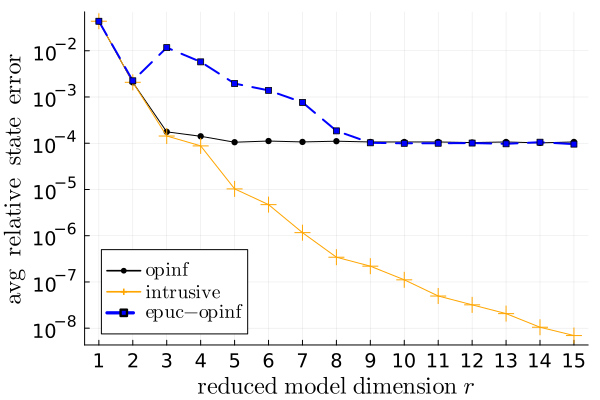

In [18]:
# Training data
c1,c2,c3,c4,c5 = palette(:default)
mean_LS_state_err = nanmedian(Data["train_state_err"][:LS], dims=2)
mean_int_state_err = median(Data["train_state_err"][:int], dims=2)
# mean_nc_state_err = mean(Data["train_state_err"][:nc_OpInf], dims=2)
# mean_ephec_state_err = mean(Data["train_state_err"][:ephec_OpInf], dims=2)
# mean_epsic_state_err = mean(Data["train_state_err"][:epsic_OpInf], dims=2)
mean_epuc_state_err = nanmedian(Data["train_state_err"][:epuc_OpInf], dims=2)

plot(rmin:rmax, mean_LS_state_err, c=:black, marker=(:circle, 3.5), label=L"\mathrm{opinf}")
plot!(rmin:rmax, mean_int_state_err, c=:orange, marker=(:cross, 8), label=L"\mathrm{intrusive}")
# plot!(rmin:rmax, mean_nc_state_err, marker=(:circle), ls=:dash, label=L"\mathrm{nc:opinf}")
# plot!(rmin:rmax, mean_ephec_state_err, c=:blue, marker=(:rect, 3), ls=:dash, lw=2, label=L"\mathrm{ep}\rm{-}\mathrm{opinf}")
# plot!(rmin:rmax, mean_epsic_state_err, marker=(:dtriangle, 5), ls=:dot, label=L"\mathrm{epsic}:\mathrm{opinf}")
plot!(rmin:rmax, mean_epuc_state_err, c=:blue, marker=(:rect, 3), ls=:dash, lw=2, label=L"\mathrm{epuc}\rm{-}\mathrm{opinf}")
plot!(yscale=:log10, majorgrid=true, legend=:bottomleft)
tmp = log10.(mean_int_state_err)
yticks!([10.0^i for i in floor(minimum(tmp))-1:ceil(maximum(tmp))+1])
xticks!(rmin:rmax)
xlabel!(L"\mathrm{reduced~model~dimension~} r")
ylabel!(L"\mathrm{avg~~relative~~state~~error}")
plot!(guidefontsize=16, tickfontsize=13,  legendfontsize=13)

#### Total Energy

In [20]:
# Training data
mean_LS_En_tr = mean(Data["train_En"][:LS])
mean_int_En_tr = mean(Data["train_En"][:int])
# mean_nc_En_tr = mean(Data["train_En"][:nc_OpInf])
# mean_ephec_En_tr = mean(Data["train_En"][:ephec_OpInf])
# mean_epsic_En_tr = mean(Data["train_En"][:epsic_OpInf])
mean_epuc_En_tr = mean(Data["train_En"][:epuc_OpInf])
mean_fom_En_tr = mean(Data["train_En"][:fom])

plot(burger.t, mean_LS_En_tr, lw=12, ls=:dash, label=L"\mathrm{LS}")
plot!(burger.t, mean_int_En_tr, lw=10, ls=:dash, label=L"\mathrm{intrusive}")
# plot!(burger.t, mean_nc_En_tr, lw=8, ls=:dot, label=L"\mathrm{nc:opinf}")
# plot!(burger.t, mean_ephec_En_tr, lw=6, ls=:dashdot, label=L"\mathrm{ephec}\rm{-}\mathrm{opinf}}")
# plot!(burger.t, mean_epsic_En_tr, lw=4, ls=:dashdotdot, label=L"\mathrm{epsic:opinf}")
plot!(burger.t, mean_epuc_En_tr, lw=6, ls=:dashdot, label=L"\mathrm{ephec}\rm{-}\mathrm{opinf}")
plot!(burger.t, mean_fom_En_tr, lw=2, label=L"\mathrm{full}")
plot!(majorgrid=true, minorgrid=true, legend=:topright)
xlabel!(L"\mathrm{time}~[s]")
ylabel!(L"\mathrm{kinetic~energy~}")
title!(L"\mathrm{Average~Energy~over~Parameter}~\mu \mathrm{~and~Dimension~} r")

In [15]:
plot(burger.t, mean_LS_En_tr - mean_fom_En_tr, lw=12, ls=:dash, label=L"\mathrm{LS}")
plot!(burger.t, mean_int_En_tr - mean_fom_En_tr, lw=10, ls=:dash, label=L"\mathrm{int}")
# plot!(burger.t, mean_nc_En_tr - mean_fom_En_tr, lw=8, ls=:dot, label=L"\mathrm{nc:opinf}")
# plot!(burger.t, mean_ephec_En_tr - mean_fom_En_tr, lw=6, ls=:dashdot, label=L"\mathrm{ephec:opinf}")
# plot!(burger.t, mean_epsic_En_tr - mean_fom_En_tr, lw=4, ls=:dashdotdot, label=L"\mathrm{epsic:opinf}")
plot!(burger.t, mean_epuc_En_tr - mean_fom_En_tr, lw=6, ls=:dashdot, label=L"\mathrm{epuc}\rm{-}\mathrm{opinf}")
plot!(majorgrid=true, minorgrid=true, legend=:bottomright)
xlabel!(L"\mathrm{time}~[s]")
ylabel!(L"\mathrm{Kinetic~Energy~Difference~from~Full~Model}~[m^2/s^2]", fontsize=(8))
title!(L"\mathrm{Average~Energy~Difference~over~Parameter}~\mu \mathrm{~and~Dimension~} r", titlefont = font(12))
plot!(guidefontsize=10)

#### Constraint Residual 

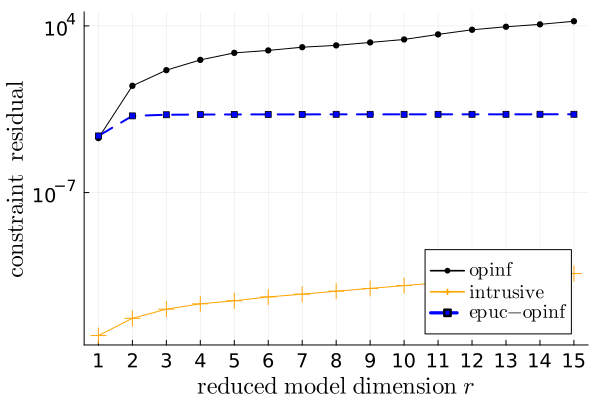

In [21]:
mean_LS_CR_tr = mean(Data["train_CR"][:LS], dims=2)
mean_int_CR_tr = mean(Data["train_CR"][:int], dims=2)
# mean_nc_CR_tr = mean(Data["train_CR"][:nc_OpInf], dims=2)
# mean_ephec_CR_tr = mean(Data["train_CR"][:ephec_OpInf], dims=2)
# mean_epsic_CR_tr = mean(Data["train_CR"][:epsic_OpInf], dims=2)
mean_epuc_CR_tr = mean(Data["train_CR"][:epuc_OpInf], dims=2)
mean_fom_CR_tr = mean(Data["train_CR"][:fom])

plot(rmin:rmax, mean_LS_CR_tr, marker=(:circle, 3.5), c=:black, label=L"\mathrm{opinf}")
plot!(rmin:rmax, mean_int_CR_tr, c=:orange, marker=(:cross, 8), label=L"\mathrm{intrusive}")
# plot!(rmin:rmax, mean_nc_CR_tr, marker=(:circle), ls=:dash, label=L"\mathrm{nc:opinf}")
# plot!(rmin:rmax, mean_ephec_CR_tr, c=:blue, marker=(:rect, 3), lw=2, ls=:dash, label=L"\mathrm{ep}\rm{-}\mathrm{opinf}")
# plot!(rmin:rmax, mean_epsic_CR_tr, marker=(:dtriangle, 5), ls=:dot, label=L"\mathrm{epsic}:\mathrm{opinf}")
plot!(rmin:rmax, mean_epuc_CR_tr, c=:blue, marker=(:rect, 3), lw=2, ls=:dash, label=L"\mathrm{epuc}\rm{-}\mathrm{opinf}")
plot!(yscale=:log10, majorgrid=true, legend=:bottomright, minorgridalpha=0.03)
yticks!(10.0 .^ [-29, -18, -7, 4])
xticks!(1:15)
xlabel!(L"\mathrm{reduced~model~dimension}~r")
ylabel!(L"\mathrm{constraint~~residual}")
plot!(guidefontsize=16, tickfontsize=13,  legendfontsize=13)

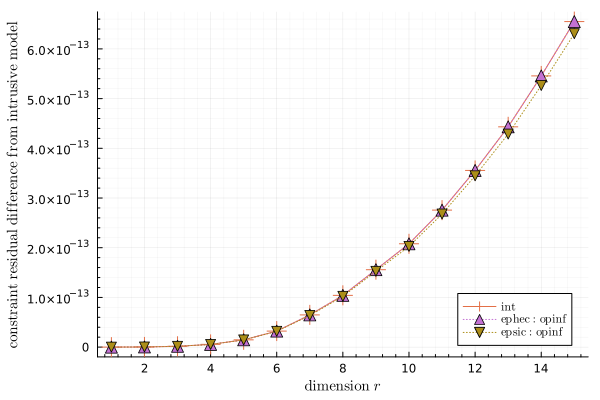

In [15]:
c1,c2,c3,c4,c5,c6 = palette(:default)
plot(rmin:rmax, mean_int_CR_tr, c=c2, marker=(:cross, 10), label=L"\mathrm{int}")
plot!(rmin:rmax, mean_ephec_CR_tr, c=c4, marker=(:utriangle, 6), ls=:dot, label=L"\mathrm{ephec}\rm{-}\mathrm{opinf}")
plot!(rmin:rmax, mean_epsic_CR_tr, c=c5, marker=(:dtriangle, 5), ls=:dot, label=L"\mathrm{epsic}\rm{-}\mathrm{opinf}")
plot!(rmin:rmax, mean_epuc_CR_tr, c=c6, marker=(:dtriangle, 5), ls=:dot, label=L"\mathrm{epuc}\rm{-}\mathrm{opinf}")
plot!(majorgrid=true, minorgrid=true, legend=:bottomright)
xlabel!(L"\mathrm{dimension}~r")
ylabel!(L"\mathrm{constraint~residual~difference~from~intrusive~model}")
plot!(guidefontsize=10)

#### Momentum 

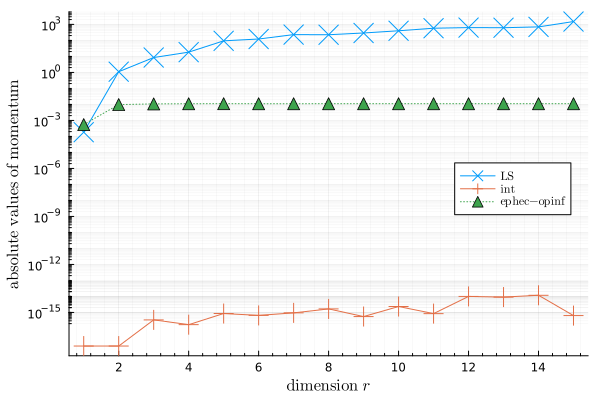

In [22]:
mean_LS_mmt_tr    = abs.(mean(Data["train_mmt"][:LS], dims=2))
mean_int_mmt_tr   = abs.(mean(Data["train_mmt"][:int], dims=2))
# mean_nc_mmt_tr    = abs.(mean(Data["train_mmt"][:nc_OpInf], dims=2))
# mean_ephec_mmt_tr = abs.(mean(Data["train_mmt"][:ephec_OpInf], dims=2))
# mean_epsic_mmt_tr = abs.(mean(Data["train_mmt"][:epsic_OpInf], dims=2))
mean_epuc_mmt_tr = abs.(mean(Data["train_mmt"][:epuc_OpInf], dims=2))
mean_fom_mmt_tr   = abs.(mean(Data["train_mmt"][:fom]))

plot(rmin:rmax, mean_LS_mmt_tr, marker=(:xcross, 10), label=L"\mathrm{LS}")
plot!(rmin:rmax, mean_int_mmt_tr, marker=(:cross, 10), label=L"\mathrm{int}")
# plot!(rmin:rmax, mean_nc_mmt_tr, marker=(:circle), ls=:dash, label=L"\mathrm{nc:opinf}")
# plot!(rmin:rmax, mean_ephec_mmt_tr, marker=(:utriangle, 6), ls=:dot, label=L"\mathrm{ephec}\rm{-}\mathrm{opinf}")
# plot!(rmin:rmax, mean_epsic_mmt_tr, marker=(:dtriangle, 5), ls=:dot, label=L"\mathrm{epsic}\rm{-}\mathrm{opinf}")
plot!(rmin:rmax, mean_epuc_mmt_tr, marker=(:utriangle, 6), ls=:dot, label=L"\mathrm{ephec}\rm{-}\mathrm{opinf}")
plot!(yscale=:log10, majorgrid=true, minorgrid=true, legend=:right)
yticks!(10.0 .^ [-18, -15, -12, -9, -6, -3, 0, 3, 6])
xlabel!(L"\mathrm{dimension}~r")
ylabel!(L"\mathrm{absolute~values~of~momentum}")


#### Constraint Violation

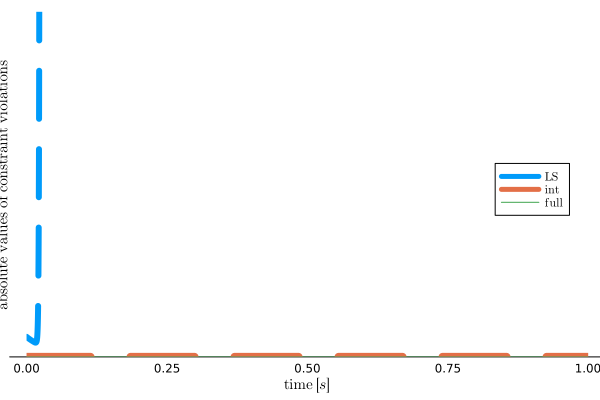

In [29]:
# Training data
mean_LS_CV_tr    = abs.(mean(Data["train_CV"][:LS]))
mean_int_CV_tr   = abs.(mean(Data["train_CV"][:int]))
# mean_nc_CV_tr    = abs.(mean(Data["train_CV"][:nc_OpInf]))
# mean_ephec_CV_tr = abs.(mean(Data["train_CV"][:ephec_OpInf]))
# mean_epsic_CV_tr = abs.(mean(Data["train_CV"][:epsic_OpInf]))
mean_epuc_CV_tr = abs.(mean(Data["train_CV"][:epuc_OpInf]))
mean_fom_CV_tr   = abs.(mean(Data["train_CV"][:fom]))

plot(burger.t, mean_LS_CV_tr, lw=6, ls=:dash, label=L"\mathrm{LS}")
plot!(burger.t, mean_int_CV_tr, lw=8, ls=:dash, label=L"\mathrm{int}")
# plot!(burger.t, mean_nc_CV_tr, lw=3, ls=:dot, label=L"\mathrm{nc:opinf}")
# plot!(burger.t, mean_ephec_CV_tr, lw=3, ls=:dashdot, label=L"\mathrm{ephec}\rm{-}\mathrm{opinf}")
# plot!(burger.t, mean_epsic_CV_tr, lw=3, ls=:dashdotdot, label=L"\mathrm{epsic}\rm{-}\mathrm{opinf}")
# plot!(burger.t, mean_epuc_CV_tr, lw=3, ls=:dashdot, label=L"\mathrm{epuc}\rm{-}\mathrm{opinf}")
plot!(burger.t, mean_fom_CV_tr, lw=1, label=L"\mathrm{full}")
plot!(yscale=:log10, majorgrid=true, minorgrid=true, legend=:right)
yticks!(10.0 .^ [-24, -21, -18, -15, -12, -9, -6, -3, 0])
xlabel!(L"\mathrm{time}~[s]")
ylabel!(L"\mathrm{absolute~values~of~constraint~violations}")
plot!(guidefontsize=10)